<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/main/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [35]:
# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [36]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

import numpy as np
import tensorflow as tf

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)

n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [37]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,evento,Vendas_do_dia,week_group
0,2011-01-29,11101,1,1,2011,d_1,0,4337,0
1,2011-01-30,11101,2,1,2011,d_2,0,4155,0
2,2011-01-31,11101,3,1,2011,d_3,0,2816,1
3,2011-02-01,11101,4,2,2011,d_4,0,3051,1
4,2011-02-02,11101,5,2,2011,d_5,0,2630,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0,3722,1
1909,2016-04-21,11612,6,4,2016,d_1910,0,3709,1
1910,2016-04-22,11612,7,4,2016,d_1911,0,4387,1
1911,2016-04-23,11613,1,4,2016,d_1912,0,5577,0


In [38]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'evento',
       'Vendas_do_dia', 'week_group'],
      dtype='object')


In [39]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


## Carregar dados (agora concatenados)

In [40]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

import numpy as np

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 7]  # Access single column directly

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

print(selected_output_column.values)

# Fit scaler to the data and transform it
selected_input_columns = scaler.fit_transform(selected_input_columns)
selected_output_column = scaler.fit_transform(selected_output_column.values.reshape(-1, 1))

import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# Assuming selected_input_columns and selected_output_column are arrays or lists
input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]

# Assuming both input_data and targets are arrays or lists
sequence_length = 7
sequences = [(input_data[i:i+sequence_length], targets[i+sequence_length]) for i in range(len(input_data) - sequence_length)]

# Extract input sequences and targets
input_sequences = [seq[0] for seq in sequences]
target_values = [seq[1] for seq in sequences]

# Convert lists to TensorFlow tensors
input_sequences_tensor = tf.constant(input_sequences, dtype=tf.float32)
target_values_tensor = tf.constant(target_values, dtype=tf.float32)

# Create a TensorFlow dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((input_sequences_tensor, target_values_tensor))

# .shuffle(buffer_size)
# Shuffle and batch your dataset
batch_size = 32
buffer_size = len(sequences)
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

for batch in dataset:
    inputs, target = batch
    # Now you can use inputs and target for training
    print(len(inputs))

[4337 4155 2816 ... 4387 5577 6113]
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [42]:
for batch in dataset:
    inputs, target = batch
    # Now you can use inputs and target for training
    print(len(inputs))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [43]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 7, 5), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.float32, name=None))>

In [44]:
inputs, targets = batch

len(inputs)

32

In [45]:
len(targets)

32

In [46]:
import tensorflow as tf

# Assuming 'dataset' is your BatchObject and 'train_split_ratio' is the ratio of data you want in the training set
def split_BatchDataset(dataset, train_split_ratio=0.85):
    # Get the total number of elements in the dataset
    total_elements = sum(1 for _ in dataset)

    # Calculate the number of elements for the training set
    train_elements = int(total_elements * train_split_ratio)

    # Create a dataset with train_elements elements for the training set
    train_dataset = dataset.take(train_elements)

    # Create a dataset with the remaining elements for the validation set
    test_dataset = dataset.skip(train_elements)

    return train_dataset, test_dataset

# Example usage
train_dataset, test_dataset = split_BatchDataset(dataset)

In [47]:
import numpy as np

# Inicializar listas para armazenar os dados
data_list = []
label_list = []

# Iterar sobre o conjunto de dados e extrair os dados e rótulos
for batch in train_dataset:
    data, label = batch  # Extrair os dados e rótulos da tupla
    data_list.append(data.numpy())  # Converter os dados para um array NumPy
    label_list.append(label.numpy())  # Converter os rótulos para um array NumPy

# Converter as listas de dados e rótulos para arrays NumPy
train_data_numpy = np.concatenate(data_list, axis=0)
train_labels_numpy = np.concatenate(label_list, axis=0)

In [48]:
# Assuming test_dataset is an instance of _SkipDataset
targets_test = []

# Iterate over the dataset to extract targets
for batch in test_dataset:
    inputs, target = batch  # Adjust this line according to the actual attribute/method name
    for value in target:
      targets_test.append(value)

targets_test = scaler.inverse_transform(targets_test)

print("Targets:", len(targets_test))

Targets: 288


In [49]:
hiperparameters = {
    'learning_rate': [0.1],
    'neurons': [50, 256, 512],
    'dense_neurons': [10],
    'activation': ['relu'],
    'dropout_rate': [0.1]
}

In [50]:
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Função para criar e treinar o modelo
#  input_shape=(7, 5),
def build_and_train_model(learning_rate, neurons, dense_neurons, activation, dropout_rate):
    model = models.Sequential()
    model.add(layers.LSTM(neurons, stateful=True, return_sequences=True, batch_input_shape=(32,7,5)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.LSTM(neurons, stateful=True, return_sequences=False))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(dense_neurons, activation))
    model.add(layers.Dense(1))  # Output layer

    #optimizer = tf.optimizers.Adam(learning_rate)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=[RootMeanSquaredError()])

    # early_stopping_callback,
    history = model.fit(train_data_numpy, train_labels_numpy, epochs=125, validation_split = 0.1, batch_size=batch_size, shuffle=False, callbacks = [callbacks])

    predictions = model.predict(test_dataset)
    #predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    mae = mean_absolute_error(scaler.transform(targets_test), predictions)
    mse = mean_squared_error(scaler.transform(targets_test), predictions)
    rmse = np.sqrt(mse)

    return [predictions, mae, mse, rmse, history, model, learning_rate, neurons, dense_neurons, activation, dropout_rate]

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='ckpt/model_RNN_{epoch}_{val_loss:.3f}.hdf5', #path where to save the model
        save_best_only=True, #overwrite the current checkpoint if and only if
        monitor='val_loss', #the val_loss score has improved
        save_weights_only=True, #if True, only the weights are saved
        verbose=1, #verbosity mode
        period=5) # gravado callback por cada 5 epochs
]

# Define the EarlyStopping callback
'''
early_stopping_callback = EarlyStopping(
    monitor='val_loss',    # Quantity to be monitored for improvement
    mini_delta = 0.1,
    # patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restores the model weights from the epoch with the best value of monitored quantity
)
'''
#early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, min_delta=0.1)

#model.fit(train_data_numpy, train_labels_numpy, epochs=1000, validation_split=0.2, batch_size=batch_size, shuffle=True)

"\nearly_stopping_callback = EarlyStopping(\n    monitor='val_loss',    # Quantity to be monitored for improvement\n    mini_delta = 0.1,\n    # patience=5,            # Number of epochs with no improvement after which training will be stopped\n    restore_best_weights=True   # Restores the model weights from the epoch with the best value of monitored quantity\n)\n"

In [51]:
import math

best_RNN = [[], 0, 0, math.inf, None, None, 0, 0, 0, 0, 0];
all_tests_tuning = []

# Iterando sobre todas as combinações de hiperparâmetros
i = 1
for learning_rate, neurons, dense_neurons, activation, dropout_rate in product(*hiperparameters.values()):
    print(f"*** Teste nº {i} ***")
    i = i+1
    print(f"Treinando modelo com learning_rate={learning_rate}, num_neurons={neurons}, num_dense_neurons={dense_neurons}, funcao_de_ativacao={activation}, dropout_rate={dropout_rate}")
    [predictions, mae, mse, rmse, history, model, learning_rate, neurons, dense_neurons, activation, dropout_rate] = build_and_train_model(learning_rate, neurons, dense_neurons, activation, dropout_rate)
    print(f'MAE:{mae}, MSE:{mse} RMSE: {rmse}')

    if (best_RNN[3] > rmse):
      best_RNN = [predictions, mae, mse, rmse, history, model, learning_rate, neurons, dense_neurons, activation, dropout_rate]

    all_tests_tuning.append([predictions, mae, mse, rmse, history, model, learning_rate, neurons, dense_neurons, activation, dropout_rate])

*** Teste nº 1 ***
Treinando modelo com learning_rate=0.1, num_neurons=50, num_dense_neurons=10, funcao_de_ativacao=relu, dropout_rate=0.1
Epoch 1/125
45/45 [==============================] - 5s 22ms/step - loss: 0.7526 - root_mean_squared_error: 0.9555 - val_loss: 0.6744 - val_root_mean_squared_error: 0.8837
Epoch 2/125
45/45 [==============================] - 0s 6ms/step - loss: 0.5855 - root_mean_squared_error: 0.7534 - val_loss: 0.4911 - val_root_mean_squared_error: 0.6730
Epoch 3/125
45/45 [==============================] - 0s 6ms/step - loss: 0.4806 - root_mean_squared_error: 0.6256 - val_loss: 0.3634 - val_root_mean_squared_error: 0.4642
Epoch 4/125
45/45 [==============================] - 0s 6ms/step - loss: 0.4918 - root_mean_squared_error: 0.6375 - val_loss: 0.3362 - val_root_mean_squared_error: 0.4313
Epoch 5/125
40/45 [=========================>....] - ETA: 0s - loss: 0.4214 - root_mean_squared_error: 0.5413
Epoch 5: val_loss improved from inf to 0.33230, saving model to ck

In [52]:
best_RNN

[array([[-1.35067761e-01],
        [-7.71885291e-02],
        [ 2.29361027e-01],
        [ 1.36837840e+00],
        [ 1.34242165e+00],
        [ 7.26450503e-01],
        [ 3.96169275e-02],
        [-5.42961508e-02],
        [ 1.08742297e-01],
        [ 2.76760906e-01],
        [ 1.68719733e+00],
        [ 1.34998369e+00],
        [ 5.36913276e-01],
        [-1.25699729e-01],
        [-1.38165474e-01],
        [-2.75252908e-02],
        [ 1.86877653e-01],
        [ 1.35072517e+00],
        [ 1.55996823e+00],
        [ 6.54600739e-01],
        [-1.47739857e-01],
        [-3.62391889e-01],
        [ 2.65780967e-02],
        [ 2.62860537e-01],
        [ 1.71901214e+00],
        [ 2.08767581e+00],
        [ 7.40643680e-01],
        [ 1.00022078e-01],
        [-9.23224166e-02],
        [-1.92464679e-01],
        [ 1.75908491e-01],
        [ 1.36641097e+00],
        [ 1.23093104e+00],
        [ 6.70157075e-01],
        [ 3.02726090e-01],
        [-9.94094610e-02],
        [ 1.31650046e-01],
 

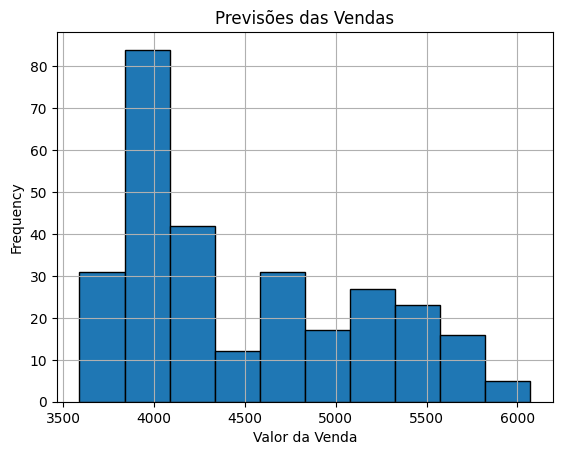

In [53]:
predictions = scaler.inverse_transform(best_RNN[0].reshape(-1,1))

# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

#print(unique_items)
#print(frequencies)

# Assuming you have a list of data points called 'data'
plt.hist(predictions, bins='auto', edgecolor='black')  # 'auto' for automatic bin size determination
plt.xlabel('Valor da Venda')
plt.ylabel('Frequency')
plt.title('Previsões das Vendas')
plt.grid(True)  # Add grid lines
plt.show()

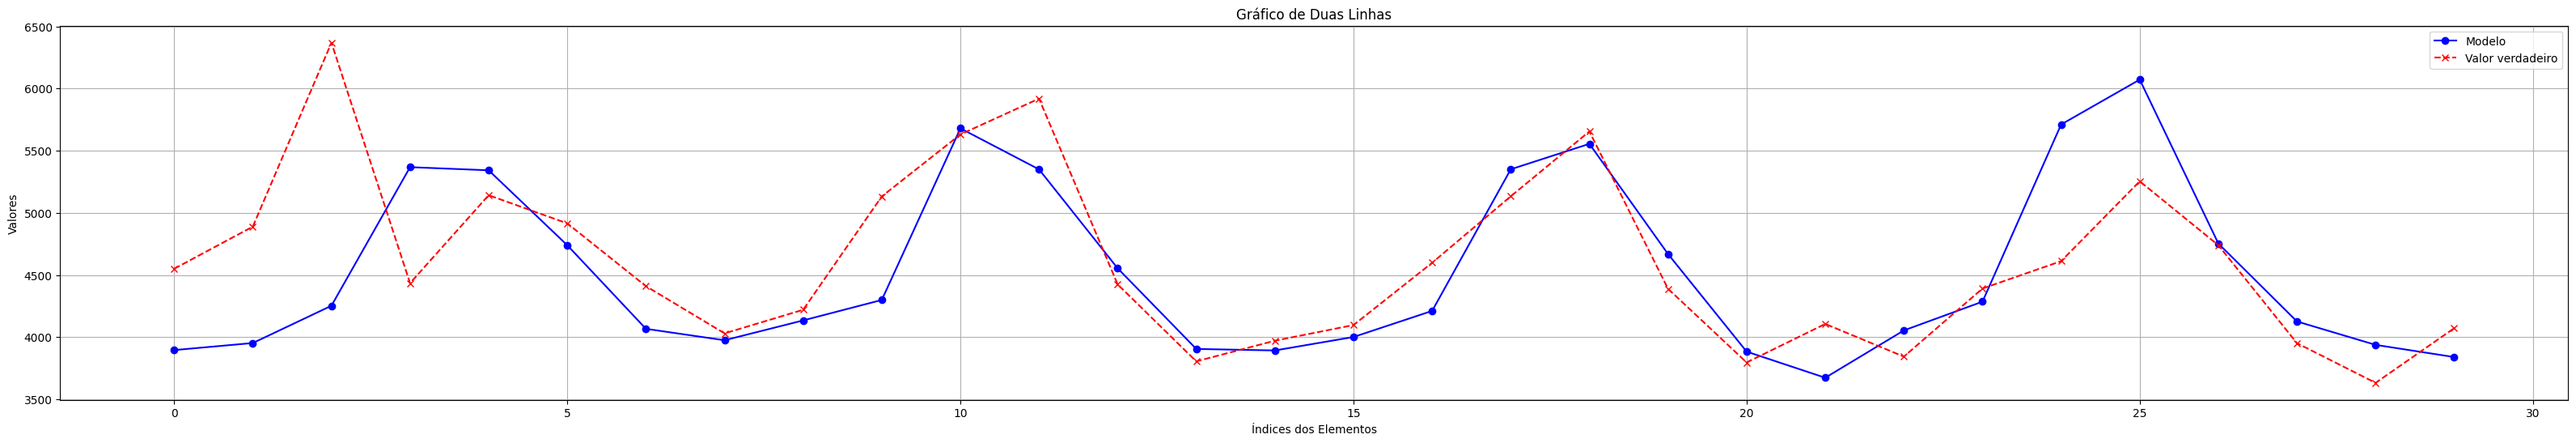

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Criar o gráfico de linhas
plt.plot(predictions[:30], label='Modelo', color='blue', linestyle='-', marker='o')
plt.plot(targets_test[:30], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [55]:
sum(targets_test - predictions)/len(predictions)

array([-87.42680889])

In [56]:
mae = mean_absolute_error(targets_test, predictions)
mse = mean_squared_error(targets_test, predictions)
rmse = np.sqrt(mse)

In [57]:
mae, mse, rmse

(442.91198496790633, 337448.847889124, 580.9034755354146)

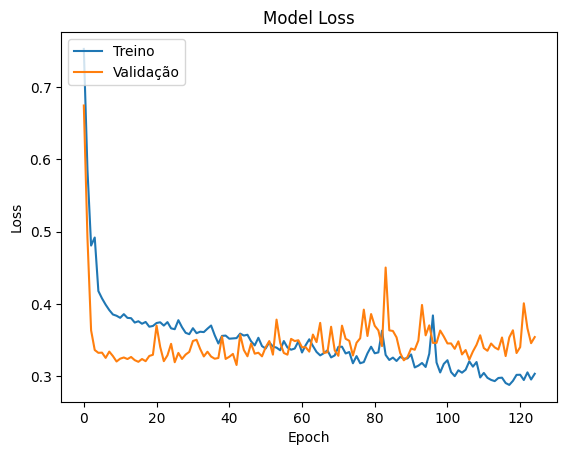

In [58]:
history_RNN = best_RNN[4]

# Gráfico evolução Loss
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

### Monte-Carlo dropout

In [59]:
# Make predictions with Monte Carlo Dropout
def predict_with_mc_dropout(model, dataset, num_samples):
    preds = []

    for _ in range(num_samples):
        predictions = model.predict(dataset)
        preds.append(predictions)

    return preds

# Example usage: assuming you have a dataset called 'test_dataset' for testing
num_samples = 250
preds = predict_with_mc_dropout(model, test_dataset, num_samples)
preds = [scaler.inverse_transform(preds[i].reshape(-1, 1)) for i in range(len(preds))]

9/9 [==============================] - 0s 3ms/step


In [60]:
len(preds)

250

In [61]:
[sublist[0] for sublist in preds]

[array([3960.7168], dtype=float32),
 array([3961.0422], dtype=float32),
 array([3961.0515], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.052], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.052], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.052], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float32),
 array([3961.0518], dtype=float

In [62]:
mean_preds = np.mean(preds, axis=0)
var_preds = np.var(preds, axis=0)
sd_preds = np.sqrt(var_preds)

In [63]:
len(mean_preds)

288

In [64]:
len(sd_preds)

288

In [65]:
#sd_preds

In [66]:
sum(targets_test - mean_preds)/len(mean_preds)

array([-267.18136788])

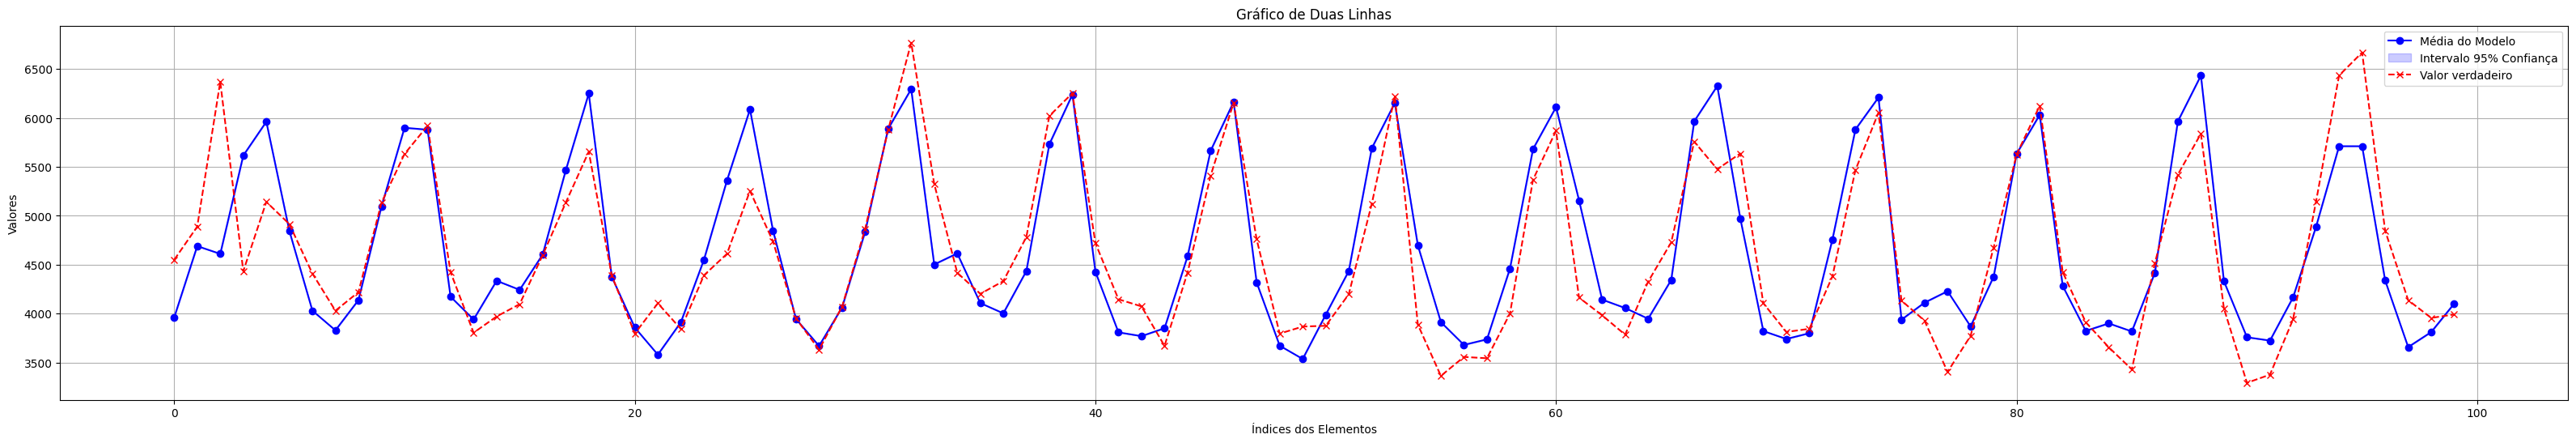

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Perform element-wise addition and subtraction
upper_bound = np.stack([mean + 1.96*sd for mean, sd in zip(mean_preds[:100], sd_preds[:100])]).ravel()
lower_bound = np.stack([mean - 1.96*sd for mean, sd in zip(mean_preds[:100], sd_preds[:100])]).ravel()

# Criar o gráfico de linhas
plt.plot(mean_preds[:100], label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(100), lower_bound, upper_bound, color='blue', alpha=0.2, label='Intervalo 95% Confiança')
plt.plot(targets_test[:100], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

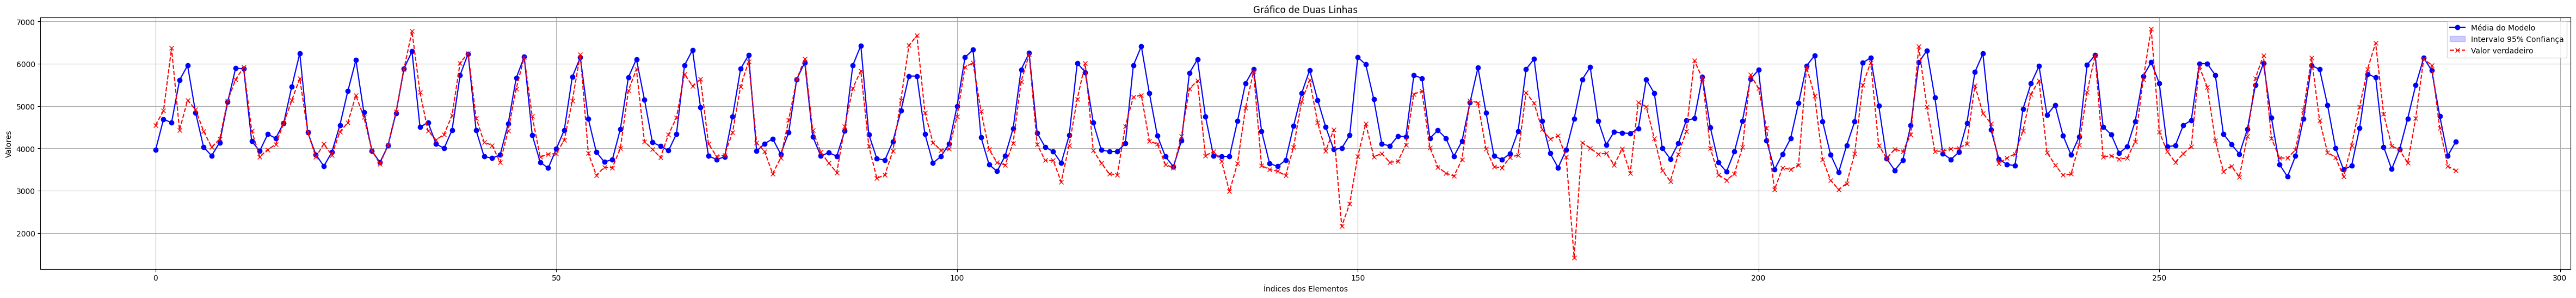

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 6))

# Perform element-wise addition and subtraction
upper_bound = np.stack([mean + 1.96*sd for mean, sd in zip(mean_preds, sd_preds)]).ravel()
lower_bound = np.stack([mean - 1.96*sd for mean, sd in zip(mean_preds, sd_preds)]).ravel()

# Criar o gráfico de linhas
plt.plot(mean_preds, label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(288), lower_bound, upper_bound, color='blue', alpha=0.2, label='Intervalo 95% Confiança')
plt.plot(targets_test, label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

### **Probabilistic** Bayesian Neural Network

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [71]:
import keras
from keras import layers
import tensorflow as tf
import tensorflow_probability as tfp

hidden_units = [50, 50]
learning_rate = 0.001

def create_probablistic_bnn_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    features = inputs
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / len(train_data_numpy),
            activation="sigmoid",
        )(features)

    # Create a probabilistic output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models

#'''
def run_experiment(model, loss, train_data_numpy, train_labels_numpy, test_dataset, num_epochs, learning_rate):
    model.compile(
        #optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        optimizer='adam',
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_data_numpy, train_labels_numpy, epochs=num_epochs, validation_split=0.2)
    print("Model training finished.")

    print("Evaluating model performance on training dataset...")
    train_loss, train_rmse = model.evaluate(train_data_numpy, train_labels_numpy, verbose=0)
    print(f"Train RMSE: {round(train_rmse, 3)}")

    print("Evaluating model performance on test dataset...")
    test_loss, test_rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(test_rmse, 3)}")
#'''
# Assuming train_data_numpy, train_labels_numpy, and test_dataset are defined elsewhere
input_shape = (7, 5)  # Example shape, replace with actual shape
prob_bnn_model = create_probablistic_bnn_model(input_shape)

'''
def negative_loglikelihood(targets, estimated_distribution, log_variance):
    return -estimated_distribution.log_prob(targets, log_variance)
'''

def negative_log_likelihood(y_true, mean_log_variance):
    mean, log_variance = mean_log_variance[:, 0], mean_log_variance[:, 1]
    nll_loss = 0.5 * (log_variance + tf.square(y_true - mean) / tf.exp(log_variance)) + 0.5 * tf.math.log(2 * np.pi)
    return tf.reduce_mean(nll_loss)

num_epochs = 200
learning_rate = 0.001
loss_fn = tf.keras.losses.MeanSquaredError()

run_experiment(prob_bnn_model, negative_log_likelihood, train_data_numpy, train_labels_numpy, test_dataset, num_epochs, learning_rate)

Start training the model...
Epoch 1/200
40/40 [==============================] - 4s 27ms/step - loss: 19.5903 - root_mean_squared_error: 2.0445 - val_loss: 11.4278 - val_root_mean_squared_error: 2.6127
Epoch 2/200
40/40 [==============================] - 0s 8ms/step - loss: 16.8416 - root_mean_squared_error: 2.5753 - val_loss: 2.6274 - val_root_mean_squared_error: 2.0293
Epoch 3/200
40/40 [==============================] - 0s 8ms/step - loss: 3.5250 - root_mean_squared_error: 2.3244 - val_loss: 3.8200 - val_root_mean_squared_error: 2.0298
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 5.2862 - root_mean_squared_error: 2.5324 - val_loss: 6.6298 - val_root_mean_squared_error: 2.4483
Epoch 5/200
40/40 [==============================] - 0s 9ms/step - loss: 4.9707 - root_mean_squared_error: 2.6758 - val_loss: 2.4288 - val_root_mean_squared_error: 2.3127
Epoch 6/200
40/40 [==============================] - 0s 9ms/step - loss: 4.9478 - root_mean_squared_error: 2.3679

In [80]:
prediction_distribution = prob_bnn_model.predict(test_dataset)
# Reshape prediction_distribution to remove the extra dimension
prediction_distribution = np.squeeze(prediction_distribution)

# Now, you can use inverse_transform()
prediction_distribution = scaler.inverse_transform(prediction_distribution)
prediction_mean = np.mean(prediction_distribution, axis=1)
prediction_stdv = np.std(prediction_distribution, axis=1)

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

9/9 [==============================] - 1s 3ms/step


In [81]:
prediction_distribution

array([[3969.6245, 3984.6523, 3959.9119, ..., 4031.9487, 3962.2034,
        4035.6423],
       [3967.2756, 3987.0474, 3966.4065, ..., 3983.313 , 4019.1287,
        4003.4756],
       [3954.3018, 3999.6   , 4044.035 , ..., 3977.5222, 3946.105 ,
        3937.213 ],
       ...,
       [3907.2888, 3908.1519, 3897.3809, ..., 3900.5645, 3903.6118,
        3912.2944],
       [3913.07  , 3899.7195, 3897.0598, ..., 3911.2305, 3916.3477,
        3914.7617],
       [3906.258 , 3913.5168, 3908.566 , ..., 3909.4338, 3913.417 ,
        3901.446 ]], dtype=float32)

In [82]:
len(prediction_distribution[0])

7

In [83]:
prediction_stdv

[29.420269012451172,
 25.912508010864258,
 36.46702194213867,
 26.35879898071289,
 28.531827926635742,
 30.445377349853516,
 54.48627853393555,
 45.38833236694336,
 42.4443473815918,
 33.76008987426758,
 33.8792839050293,
 23.739816665649414,
 27.87686538696289,
 32.895442962646484,
 29.427549362182617,
 34.287601470947266,
 26.04833221435547,
 37.1378059387207,
 61.99637985229492,
 24.733566284179688,
 34.10622024536133,
 41.37614059448242,
 37.45370864868164,
 27.498857498168945,
 40.52672576904297,
 33.520782470703125,
 18.818164825439453,
 21.204429626464844,
 17.942441940307617,
 36.76476287841797,
 40.02356719970703,
 33.2951774597168,
 22.20504379272461,
 9.002188682556152,
 8.007121086120605,
 13.253596305847168,
 12.535112380981445,
 13.135062217712402,
 20.167394638061523,
 12.143271446228027,
 27.3570556640625,
 22.218189239501953,
 32.734745025634766,
 23.102197647094727,
 18.968477249145508,
 23.852649688720703,
 20.855253219604492,
 22.53618621826172,
 19.823131561279297,

In [84]:
upper, lower

([4046.808837890625,
  4046.390625,
  4053.400634765625,
  4057.664794921875,
  4036.4560546875,
  4028.7568359375,
  4082.2109375,
  4074.05224609375,
  4077.251708984375,
  4073.755859375,
  4057.08447265625,
  4034.795654296875,
  4048.55908203125,
  4065.930419921875,
  4048.01611328125,
  4066.13916015625,
  4049.230224609375,
  4059.11865234375,
  4115.2744140625,
  4068.50341796875,
  4049.8779296875,
  4045.696044921875,
  4046.70458984375,
  4023.623046875,
  4068.990234375,
  4064.595947265625,
  4034.907470703125,
  4020.396728515625,
  3993.075439453125,
  4053.632568359375,
  4070.127685546875,
  4050.7607421875,
  4016.70703125,
  3982.38330078125,
  3980.473388671875,
  3994.489013671875,
  3989.71875,
  3986.059326171875,
  4011.778564453125,
  3991.603271484375,
  4043.85595703125,
  4027.633056640625,
  4040.277099609375,
  4025.574951171875,
  4030.050048828125,
  4031.96484375,
  4023.6748046875,
  4032.631591796875,
  4020.642822265625,
  4017.268310546875,
  4020.

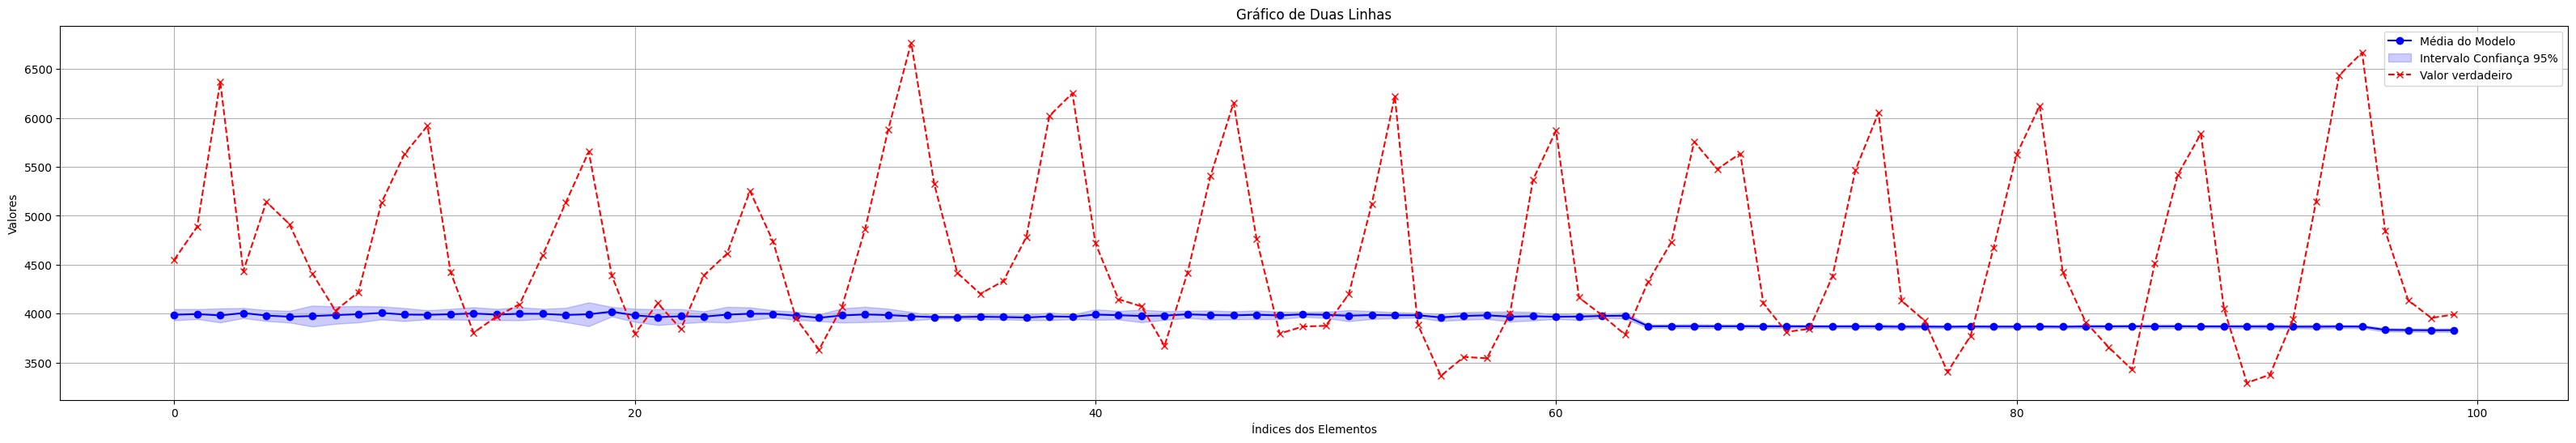

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Criar o gráfico de linhas
plt.plot(prediction_mean[:100], label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(100), lower[:100], upper[:100], color='blue', alpha=0.2, label='Intervalo Confiança 95%')
plt.plot(targets_test[:100], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

### Análises dos dados

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

In [ ]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado